In [2]:
import re
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import KernelPCA, PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN, SVMSMOTE

from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.model_selection import KFold, RandomizedSearchCV,GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, make_scorer, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


In [7]:
# Declare variables
base_path_normal_train = 'Saved_Embeddings/Normal/'
base_path_abnormal_train = 'Saved_Embeddings/Abnormal/'
base_path_normal_test = 'Saved_Embeddings/Normal_test/'
base_path_abnormal_test = 'Saved_Embeddings/Abnormal_test/'
use_dimensionality_reduction = True
use_scaler = True
use_age_gender_data = False
use_oversampling = True

In [8]:
#Data Loading and scaling

def load_all_image_embeddings(base_path_normal, base_path_abnormal, age_gender_data):
    embeddings = []
    labels = []
    age_list = []
    gender_list = []
    normal_age_gender_data = age_gender_data[0]
    abnormal_age_gender_data = age_gender_data[1]
    normal_id_list = list(normal_age_gender_data['ID'])
    abnormal_id_list = list(abnormal_age_gender_data['ID'])
    for k in os.listdir(base_path_normal):
        age, gender = None, None
        id_cleaned = int(''.join(filter(str.isdigit, k)))
        if id_cleaned in normal_id_list:
            _, gender, age = list(normal_age_gender_data.loc[normal_age_gender_data['ID'] == id_cleaned].values.ravel())
        embeddings.append(np.load(base_path_normal + k))
        age_list.append(age)
        gender_list.append(gender)
        labels.append(0)
    for s in os.listdir(base_path_abnormal):
        age, gender = None, None
        id_cleaned = int(''.join(filter(str.isdigit, s)))
        if id_cleaned in abnormal_id_list:
            _, gender, age = list(
                abnormal_age_gender_data.loc[abnormal_age_gender_data['ID'] == id_cleaned].values.ravel())
        embeddings.append(np.load(base_path_abnormal + s))
        labels.append(1)
        age_list.append(age)
        gender_list.append(gender)
    return np.vstack(embeddings), np.array(labels), age_list, gender_list


def load_all_data():
    normal_train, abnormal_train, normal_test, abnormal_test = add_age_gender_data()

    X_train, labels_train, age_list_train, gender_list_train = load_all_image_embeddings(base_path_normal_train,
                                                                                         base_path_abnormal_train,
                                                                                         (normal_train, abnormal_train))
    X_test, labels_test, age_list_test, gender_list_test = load_all_image_embeddings(base_path_normal_test,
                                                                                     base_path_abnormal_test,
                                                                                     (normal_test, abnormal_test))
    #return X_train, labels_train, X_test, labels_test, age_list_train, age_list_test, gender_list_train, gender_list_test
    return X_train, labels_train, X_test, labels_test

def add_age_gender_data():
    normal_train = pd.read_excel('age and gender.xlsx', sheet_name=0)
    abnormal_train = pd.read_excel('age and gender.xlsx', sheet_name=1)
    normal_test = pd.read_excel('age and gender.xlsx', sheet_name=2)
    abnormal_test = pd.read_excel('age and gender.xlsx', sheet_name=3)
    return normal_train, abnormal_train, normal_test, abnormal_test


def add_age_gender_to_data(data, agedata, gender_data):
    temp_array = []
    for index, k in enumerate(data):
        temp_k = list(k) + [agedata[index], gender_data[index]]
        temp_array.append(temp_k)
    return np.array(temp_array)


def do_scaling(X_train, X_test, method='standard'):
    if method == 'standard':
        scaler = StandardScaler()
        scaler.fit(X_train)
        print("Scaler used :- ", str("Standard Scaler"))
        return scaler.transform(X_train), scaler.transform(X_test)
    elif method == 'minmax':
        scaler = MinMaxScaler()
        scaler.fit(X_train)
        print("Scaler used :- ", str("MinMax Scaler"))
        return scaler.transform(X_train), scaler.transform(X_test)
    else:
        return 'Not a valid method'



In [9]:
# Confusion Matrix
def cm_display(arr1, arr2):
    
    # imb_svm_df
    cm = confusion_matrix(  arr1, arr2)
    plt.figure(figsize = (5,5))
    ConfusionMatrixDisplay(cm).plot(cmap = 'viridis')

In [10]:
# Oversampling

def use_oversampling_method(X_train, Y_train, method='adasyn'):
    if method == 'smote':
        oversample = SMOTE()
        X_train, Y_train = oversample.fit_resample(X_train, Y_train)
        print("oversampling used :- ", str(method))
        return X_train, Y_train
    elif method == 'randomsampler': #vulnerable to overfitting
        random = RandomOverSampler()
        X_train, Y_train = random.fit_resample(X_train, Y_train)
        print("oversampling used :- ", str(method))
        return X_train, Y_train
    elif method == 'adasyn':
        adasyn = ADASYN()
        X_train, Y_train = adasyn.fit_resample(X_train, Y_train)
        print("oversampling used :- ", str(method))
        return X_train, Y_train
    elif method == "svmsmote":
        svmsmote = SVMSMOTE()
        X_train, Y_train = svmsmote.fit_resample(X_train, Y_train)
        print("oversampling used :- ", str(method))
        return X_train, Y_train
    else:
        print('Wrong Method')


In [11]:
# Dimensionality Reduction
def do_dimensionality_reduction(X_train, X_test, Y_train, Y_test, method='kernelpca'):
    if method == 'kernelpca':
        earlier_dimension = X_train.shape[1]
        kernelpca = KernelPCA()
        kernelpca.fit(X_train)
        X_train = kernelpca.transform(X_train)
        X_test = kernelpca.transform(X_test)
        print("Dimension Reduced from :- ", str(earlier_dimension), " to :- ", str(X_train.shape[1]), " Using :- ",
              str(method))
        return X_train, X_test, Y_train, Y_test
    elif method == 'pca':
        pca = PCA()
        pca.fit(X_train)
        earlier_dimension = X_train.shape[1]
        X_train = pca.transform(X_train)
        X_test = pca.transform(X_test)
        print("Dimension Reduced from :- ", str(earlier_dimension), " to :- ", str(X_train.shape[1]), " Using :- ",
              str(method))
        return X_train, X_test, Y_train, Y_test
    elif method == 'svd':
        svd = TruncatedSVD()
        svd.fit(X_train)
        earlier_dimension = X_train.shape[1]
        X_train = svd.transform(X_train)
        X_test = svd.transform(X_test)
        print("Dimension Reduced from :- ", str(earlier_dimension), " to :- ", str(X_train.shape[1]), " Using :- ",
              str(method))
        return X_train, X_test, Y_train, Y_test
    elif method == 'tsne':
        earlier_dimension = X_train.shape[1]
        X = np.concatenate([X_train, X_test], axis=0)
        Y = np.concatenate([Y_train, Y_test], axis=0)
        X_embedded = TSNE(n_components=3, init = 'random', random_state = 0).fit_transform(X) #random_state = 42, n_components=3
        X_train, X_test, Y_train, Y_test = train_test_split(X_embedded, Y, test_size=.1)
        print("Dimension Reduced from :- ", str(earlier_dimension), " to :- ", str(X_train.shape[1]), " Using :- ",
              str(method))
        return X_train, X_test, Y_train, Y_test



In [12]:
# Models
def svm_model(X_train, Y_train, X_test, Y_test, params ):
    print(f'===================== Running the SVM model  with {params}')
#     svm_classifier = SVC(kernel=params['kernel'], gamma = params['gamma'], C = params['C'])
    svm_classifier = SVC().set_params(**params)
    svm_classifier.fit(X_train, Y_train)
    pred_labels_test= svm_classifier.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(Y_test, pred_labels_test).ravel()
    precision = tp / (tp + fp) #should be fp instead of tn
    recall = tp / (tp + fn)
    
    if (precision > 0 ) and (recall > 0):
        
        f1 = 2 * precision * recall / (precision + recall)
        print('----------------', f1, recall, precision, sep = '\t')
    else:
        print('----',  precision, recall, sep = '\t')

    accuracy, f1score, recall, precision=calculate_all_acc_parameters(pred_labels_test, Y_test)
    print(accuracy,f1score,recall,precision)
    cm_display(Y_test, pred_labels_test)
    
    return Y_test, pred_labels_test


def svm_model_ten_cv(data_X, data_Y,model_name='svm', folds=10):
#     folds = 10 #temporarily reduced to 5 from 10
    Accuracy, F1_score, Recall, Precision = [], [], [], []
    kfold = KFold(n_splits=folds, random_state=1, shuffle=True)
    count = 1
    Fold_Number = []
    '''
    save the best params for each CV in a list
    '''
    best_params_list = []
    for train_index, test_index in kfold.split(data_X):
        print(f'===================================================   CV.{count}  ======================================')
        X_train, X_test = data_X[train_index], data_X[test_index]
        y_train, y_test = data_Y[train_index], data_Y[test_index]
        print('Searching for parameters using GridSearchCV.........................')
        best_parameters = grid_search_parameters(X_train, y_train)
        print(f'Parameters found: {best_parameters}')
        best_params_list.append(best_parameters)
        svm_classifier = SVC().set_params(**best_parameters)
        svm_classifier.fit(X_train, y_train)
        y_test_pred = svm_classifier.predict(X_test)
#         print(y_test_pred, y_test)
        print(f'Size of CV test data: {len(y_test)}')
        accuracy, f1score, recall, precision = calculate_all_acc_parameters(y_test_pred, y_test)
        print('CV F1Score: ',f1score)
        Accuracy.append(accuracy)
        F1_score.append(f1score)
        Recall.append(recall)
        Precision.append(precision)
        Fold_Number.append('Fold.' + str(count))
        count = count + 1
    print('Accuracy', np.mean(Accuracy))
    print('F1 Score', np.mean(F1_score))
    print('Recall', np.mean(Recall))
    print('Precision', np.mean(Precision))
    return [Fold_Number, Accuracy, F1_score, Recall, Precision] , best_params_list #added best parameters in the return variables


In [13]:
# Because the system is currently vulberable to overfitting, let's set high values of C and low values of gamma
# Replace C:[0.1, 1, 10, 100, 1000, .001] with C:[ 100, 1000, 10e4] 
# Replace gamma:[1, 0.1, 0.01, 0.001, 0.0001,10,100] with gamma:[0.01, 0.001, 0.10e-4]
# gamma is useful only for rbf and sigmoid kernels, we are not going to use it for other kernels (Run 'rbf' separately)

def grid_search_parameters(Data_X, Data_Y):

    param_grid = {'C': [1.0, 10], # added 0.01
                  'gamma': [1.0, 0.1 ],
                  'kernel': ['rbf']}
    fs = make_scorer(custom_scorer, actual_scorer = f1_score)
    
    grid = GridSearchCV(SVC(), param_grid, verbose=3, cv=3, scoring=fs) # temporarily reduced from 5 to 3
    grid.fit(Data_X, Data_Y)
    return grid.best_params_

def calculate_all_acc_parameters(predicted_labels, y_true):
    return accuracy_score(y_true, predicted_labels), f1_score(y_true, predicted_labels), \
recall_score(y_true, predicted_labels), \
precision_score(y_true, predicted_labels)


def custom_scorer(y_true, y_pred, actual_scorer):
    score = np.nan
    try:
        score = actual_scorer(y_true, y_pred)
    except Exception: 
        pass

    return score

Data size.................................
(982, 2048)
(100, 2048)
...............................................
oversampling used :-  randomsampler
Data size after oversampling ..................
(1794, 2048)
(100, 2048)
...............................................
Scaler used :-  Standard Scaler


C:\Users\DELL\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Dimension Reduced from :-  2048  to :-  3  Using :-  tsne

Data size after TSNE: .........................
(1704, 3)
(190, 3)
...............................................
===================== Running the SVM model  with {'C': 100000.0, 'gamma': 0.0001, 'kernel': 'rbf'}
----------------	0.7570621468926554	0.6979166666666666	0.8271604938271605
0.7736842105263158 0.7570621468926554 0.6979166666666666 0.8271604938271605
======================================== Starting CV SVM Model ====================================
===================================================   CV.1  ======================================
Searching for parameters using GridSearchCV.........................
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3] END ......C=1.0, gamma=1.0, kernel=rbf;, score=0.324 total time=   0.3s
[CV 2/3] END ......C=1.0, gamma=1.0, kernel=rbf;, score=0.374 total time=   0.2s
[CV 3/3] END ......C=1.0, gamma=1.0, kernel=rbf;, score=0.352 total time=   0.2s
[CV 1

Parameters found: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Size of CV test data: 170
CV F1Score:  0.9940828402366864
===================================================   CV.7  ======================================
Searching for parameters using GridSearchCV.........................
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3] END ......C=1.0, gamma=1.0, kernel=rbf;, score=0.315 total time=   0.4s
[CV 2/3] END ......C=1.0, gamma=1.0, kernel=rbf;, score=0.356 total time=   0.8s
[CV 3/3] END ......C=1.0, gamma=1.0, kernel=rbf;, score=0.338 total time=   0.4s
[CV 1/3] END ......C=1.0, gamma=0.1, kernel=rbf;, score=0.946 total time=   0.1s
[CV 2/3] END ......C=1.0, gamma=0.1, kernel=rbf;, score=0.948 total time=   0.4s
[CV 3/3] END ......C=1.0, gamma=0.1, kernel=rbf;, score=0.946 total time=   0.2s
[CV 1/3] END .......C=10, gamma=1.0, kernel=rbf;, score=0.315 total time=   0.4s
[CV 2/3] END .......C=10, gamma=1.0, kernel=rbf;, score=0.356 total time=   0.2s
[CV 3/3

<ipython-input-9-45ac68e6ec53>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize = (5,5))


<Figure size 360x360 with 0 Axes>

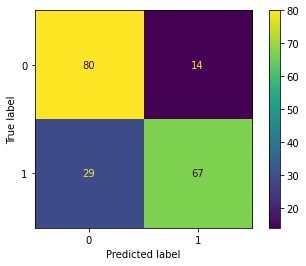

<Figure size 360x360 with 0 Axes>

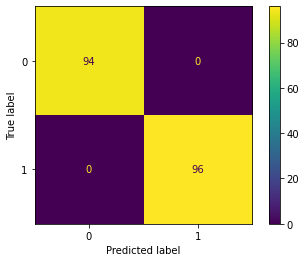

<Figure size 360x360 with 0 Axes>

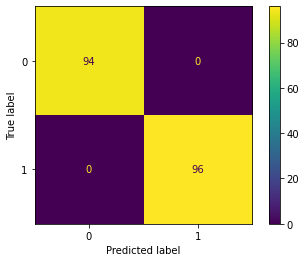

<Figure size 360x360 with 0 Axes>

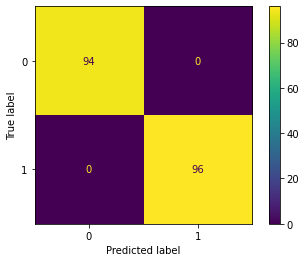

<Figure size 360x360 with 0 Axes>

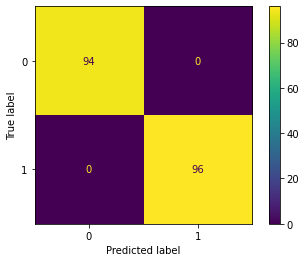

<Figure size 360x360 with 0 Axes>

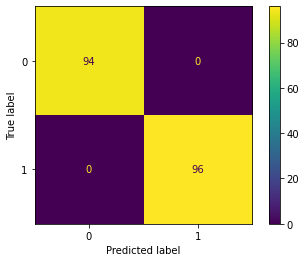

<Figure size 360x360 with 0 Axes>

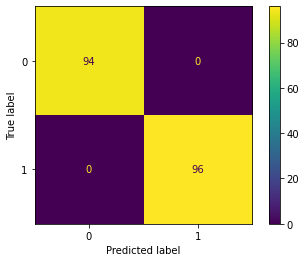

<Figure size 360x360 with 0 Axes>

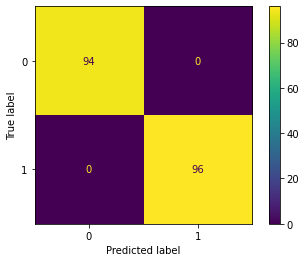

<Figure size 360x360 with 0 Axes>

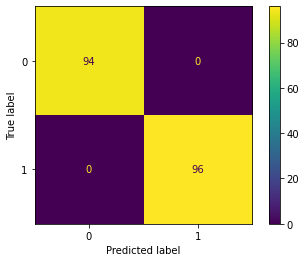

<Figure size 360x360 with 0 Axes>

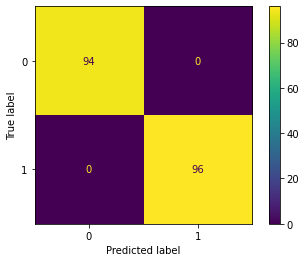

<Figure size 360x360 with 0 Axes>

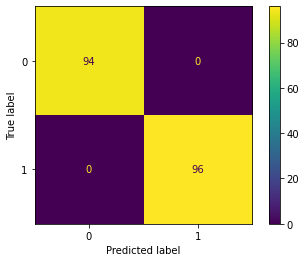

In [14]:

X_train, Y_train, X_test, Y_test = load_all_data()
# X_train, Y_train, X_test, Y_test, age_list_train, age_list_test, gender_list_train, gender_list_test = load_all_data()

print('Data size.................................')
print(X_train.shape)
print(X_test.shape)
print('...............................................')

'''
oversampling was here. Which should go first, oversampling or dimensionality reduction?
'''
if use_oversampling:
    X_train, Y_train = use_oversampling_method(X_train, Y_train, method='randomsampler')

print('Data size after oversampling ..................')
print(X_train.shape)
print(X_test.shape)
print('...............................................')


if use_scaler:
    X_train, X_test = do_scaling(X_train, X_test)

if use_dimensionality_reduction:
    X_train, X_test, Y_train, Y_test = do_dimensionality_reduction(X_train, X_test, Y_train, Y_test, method='tsne')

print('\nData size after TSNE: .........................')
print(X_train.shape)
print(X_test.shape)
print('...............................................')





train_array = []


params_initial = {'C': 10e4, 'gamma': 10e-5, 'kernel': 'rbf'}
result =svm_model(X_train, Y_train, X_test, Y_test, params_initial)
marker = str(datetime.datetime.now()).replace(':','').replace(' ','_').replace('-','')
pd.DataFrame(result).to_csv(f'svm_results_initial{marker}.csv', index=False)



print('======================================== Starting CV SVM Model ====================================')

X = X_train
Y = Y_train

performance, best_params_list  = svm_model_ten_cv(X, Y, folds=10)
marker = str(datetime.datetime.now()).replace(':','').replace(' ','_').replace('-','').split('.')[0]
pd.DataFrame(np.array(performance).T,\
             columns=['Fold_Number', 'Accuracy', 'F1_Score', 'Recall', 'Precision']).to_csv(f'CV_Results {marker}.csv', index=False)


# marker = str(datetime.datetime.now()).replace(':','').replace(' ','_').replace('-','')

for bp in best_params_list:
    print(f'Parameters {bp}')
    result =svm_model(X_train, Y_train, X_test, Y_test, bp)
    marker = str(datetime.datetime.now()).replace(':','').replace(' ','_').replace('-','').split('.')[0]
    pd.DataFrame(result).to_csv(f'svm_results_{marker}.csv', index=False)
    print('============================')

In [22]:
# def tsne_reduction(X_train, X_test, Y_train, Y_test, rand):
#     earlier_dimension = X_train.shape[1]
#     X = np.concatenate([X_train, X_test], axis=0)
#     Y = np.concatenate([Y_train, Y_test], axis=0)
#     X_embedded = TSNE(n_components=3, init = 'pca', random_state = rand).fit_transform(X) #random_state = 42, n_components=3
#     X_train, X_test, Y_train, Y_test = train_test_split(X_embedded, Y, test_size=.1)
#     print("Dimension Reduced from :- ", str(earlier_dimension), " to :- ", str(X_train.shape[1]), " Using :- ",
#           str(method))
#     return X_train, X_test, Y_train, Y_test


In [23]:
# best_ps={'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


In [24]:
# for i in range(100):
    

In [3]:
GridSearchCV?